In [1]:
from FPSim2.scripts.create_fpsim2_fp_db import create_db_file_parallel
import dask.dataframe as dd
import os
from FPSim2 import FPSim2Engine

In [2]:
data = dd.read_parquet("test_files/*.parquet")
len(data)

22145225

In [2]:
create_db_file_parallel(
    smi_file="all_molecules.smi", 
    out_file="pattern_screenout.h5", 
    fp_type="RDKitPattern", 
    fp_params={}, 
    full_sanitization=False, 
    num_processes=4
)

In [9]:
os.path.getsize('pattern_screenout.h5') /1024**3 * 134_100_000_000/22145225

19391.0087247568

### Search

In [44]:
from rdkit import Chem, RDLogger
from rdkit.Chem.MolStandardize import rdMolStandardize
import pandas as pd
import datamol as dm
from dask.distributed import Client
from functools import partial

In [4]:
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 31.08 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33195,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46723,Total threads: 2
Dashboard: http://127.0.0.1:42505/status,Memory: 7.77 GiB
Nanny: tcp://127.0.0.1:36237,


In [6]:
fp_filename = "pattern_screenout.h5"
fpe = FPSim2Engine(fp_filename, in_memory_fps=False)

query = 'CC(=O)Oc1ccccc1C(=O)O'
results = fpe.on_disk_substructure(query, n_workers=4)

In [25]:
sort = sorted([int(s) for s in results])

In [12]:
import duckdb 
db = duckdb.connect()

In [26]:
res = db.execute(f"SELECT SMILES, num_ID FROM read_parquet($path) WHERE num_ID in $query", {"path":["test_files/*.parquet"],  "query": sort}).df()

In [27]:
len(sort)

2305

In [ ]:
query_mol = Chem.MolFromSmiles(query)
def match_smiles(smi, query_mol=query_mol):
    mol = dm.to_mol(smi)
    return mol.HasSubstructMatch(query_mol)

In [46]:
a = res.drop_duplicates(subset=["num_ID"])
#mols = dm.from_df(a, smiles_column="SMILES")
mask = dm.parallelized(partial(match_smiles, query_mol=query_mol), a["SMILES"], n_jobs=4, progress=False, scheduler="threads")

Traceback (most recent call last):
  File "/home/ruite/miniforge3/envs/ai_factory/lib/python3.13/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "UNREGISTER","rtype":"semlock","base64_name" for automatic cleanup: unknown resource type ("L2xva3ktMzE5NzUtaGN4NHBoczY="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/home/ruite/miniforge3/envs/ai_factory/lib/python3.13/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "UNREGISTER","rtype":"semlock","base64_name" for automatic cleanup: unknown resource type ("L2xva3ktMzE5NzUtaWJjY2I4djU="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/home/ruite/miniforge3/en

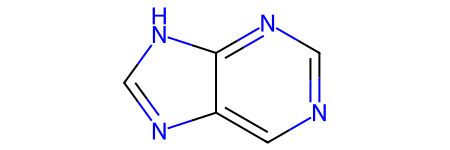

In [ ]:


p = Chem.MolFromSmiles('[nH]1cnc2cncnc21')
p

In [10]:
a = pd.Series({2:4,5:7})
a.rename("tanimoto")

2    4
5    7
Name: tanimoto, dtype: int64

In [9]:
has = data[data.map_partitions(lambda df: df["SMILES"].map(macth_smiles), meta=("SMILES", bool))]

In [10]:
res = has.compute()

### Generate conformers

In [41]:
import datamol as dm
from molfeat.trans.fp import FPVecTransformer
from rdkit import DataStructs

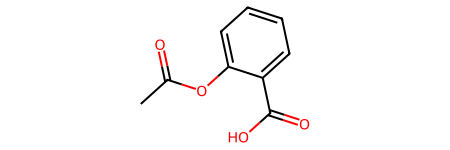

In [11]:
smi = "O=C(C)Oc1ccccc1C(=O)O"
mol = dm.to_mol(smi)
smi = dm.to_smiles(mol, canonical=True, isomeric=False)
mol = dm.to_mol(smi)
mol

In [22]:
a = dm.conformers.generate(mol, n_confs=10, align_conformers=True, minimize_energy=True)
conf = a.GetConformers()

In [ ]:
import numpy as np

def normalized_distances_to_reference(vectors, reference_idx=0):
    """
    1. Normalize features to comparable ranges
    2. Compute distances in normalized space
    """
    # Method A: Min-max normalization per feature
    min_vals = vectors.min(axis=0)
    max_vals = vectors.max(axis=0)
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1  # Avoid division by zero
    normalized = (vectors - min_vals) / range_vals
    
    # Reference in normalized space
    ref_norm = normalized[reference_idx]
    
    # Distances in normalized space
    distances = np.sqrt(np.sum((normalized - ref_norm) ** 2, axis=1))
    ranking = np.argsort(distances)
    
    return distances, ranking, normalized

# Usage


# Example usage
vectors = np.array([
    [0, 10, 100],   # Small, medium, large counts
    [5, 20, 50],
    [1, 5, 200],
    [0, 0, 300]
])

distances, ranking, normalized = normalized_distances_to_reference(vectors, 0)

[  5  20 250]
[  5  20 250]


In [61]:
vectors.min(axis=0)

array([ 0,  0, 50])

In [52]:
ranking

array([0, 2, 3, 1])

In [63]:
distances

array([0.        , 1.13578167, 0.51234754, 0.94339811])